In [1]:
import math
import os
import os.path as osp
import random
import sys
from datetime import datetime
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.utils.data as tordata
from torch.optim import lr_scheduler
#from network import TripletLoss, SetNet
#from network import vgg_c3d,C3D_VGG_angle,transview
from utils import TripletSampler
os.environ["CUDA_VISIBLE_DEVICES"]='0'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return F.leaky_relu(x, inplace=True)



class Feed_Forward(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,dropout=0.5, **kwargs):
        super(Feed_Forward, self).__init__()
        self.conv = nn.Conv2d(in_channels, hidden_channels, (1,1), bias=False, **kwargs)
        self.relu=nn.LeakyReLU(inplace=True)
        self.drop=nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, (1,1), bias=False, **kwargs)
        self.upsample=nn.Conv2d(in_channels, out_channels, (1,1), bias=False, **kwargs)
        self.norm = nn.LayerNorm(out_channels)
    def forward(self, x):
        x_ori=x.clone()
        x=self.conv(x)
        x=self.relu(x)
        x=self.drop(x)
        x=self.conv2(x) # n c h w
        x=x.permute(0,2,3,1).contiguous()
        x=self.norm(x).permute(0,3,1,2).contiguous()

        return x+self.upsample(x_ori)

class Feed_Forward_ori(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Non_local(nn.Module):
    def __init__(self, in_channels, reduc_ratio=4):
        super(Non_local, self).__init__()

        self.in_channels = in_channels
        self.inter_channels = in_channels // reduc_ratio

        self.g = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                      kernel_size=1, stride=1, padding=0)

        self.W = nn.Sequential(
            nn.Conv2d(in_channels=self.inter_channels, out_channels=self.in_channels,
                    kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.in_channels),
        )
        nn.init.constant_(self.W[1].weight, 0.0)
        nn.init.constant_(self.W[1].bias, 0.0)

        self.theta = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        '''
                :param x: (b, c, h, w)
                :return x: (b, c, h, w)
        '''
        batch_size = x.size(0)
        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        #f_div_C = f / N
        f_div_C=F.softmax(f,-1)
        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x
        return z





class Attention_ori(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        
        # get q,k,v from a single weight matrix
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        #self.to_q=nn.Linear(dim, inner_dim , bias = False)
        #self.to_k=nn.Linear(dim, inner_dim , bias = False)
        #self.to_v=nn.Linear(dim, inner_dim , bias = False)
        #self.to_qkv.apply(weights_init_kaiming)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)
        #self.to_out.apply(weights_init_kaiming)
    def forward(self, x, mask = None):
        #print(x.shape)
        x_ori=x.clone()
        #ipdb.set_trace()
        # x:[batch_size, patch_num, pathch_embedding_dim]
        b, n, _, h = *x.shape, self.heads
        #print(b, n, _, h)
        # get qkv tuple:([batch, patch_num, head_num*head_dim],[...],[...])
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        
        # split q,k,v from [batch, patch_num, head_num*head_dim] -> [batch, head_num, patch_num, head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        #print(q.shape,v.shape)
        #transpose(k) * q / sqrt(head_dim) -> [batch, head_num, patch_num, patch_num]
        #dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        q=q.contiguous().view(b*h,n,-1)
        k=k.contiguous().view(b*h,-1,n).contiguous()
        dots=torch.bmm(q,k)
        dots=dots.view(b,h,n,n)
        
        #print(dots.shape)
        
        
        # mask value: -inf
        '''
        mask_value = -10000000000000

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask
        '''
        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)

        # value * attention matrix -> output
        
        attn=attn.view(b*h,n,-1)
        v=v.contiguous().view(b*h,n,-1).contiguous()
        out=torch.bmm(attn,v)
        out=out.view(b,h,n,-1)
        
        #out = torch.einsum('bhij,bhjd->bhid', attn, v)

        # cat all output -> [batch, patch_num, head_num*head_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')
        #out = out.view(b,h,n,d).permute(0,2,1,3).contiguous()
        #out=out.view(b,n,h*d)
        # Linear + Dropout
        out =  self.to_out(out)
        out =  self.norm(out)
        # out: [batch, patch_num, embedding_dim]
        return out+x_ori,attn



class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        
        # get q,k,v from a single weight matrix
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        #self.to_q=nn.Linear(dim, inner_dim , bias = False)
        #self.to_k=nn.Linear(dim, inner_dim , bias = False)
        #self.to_v=nn.Linear(dim, inner_dim , bias = False)
        #self.to_qkv.apply(weights_init_kaiming)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)
        #self.to_out.apply(weights_init_kaiming)
    def forward(self, x, mask = None):
        # bt c h w
        bt,c,he,wi=x.shape
        #print(x.shape)
        x_ori=x.clone()
        x=x.permute(0,2,3,1).contiguous()
        x=x.view(bt,he*wi,c)
        #ipdb.set_trace()
        # x:[batch_size, patch_num, pathch_embedding_dim]
        b, n, _, h = *x.shape, self.heads
        #print(b, n, _, h)
        # get qkv tuple:([batch, patch_num, head_num*head_dim],[...],[...])
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        
        # split q,k,v from [batch, patch_num, head_num*head_dim] -> [batch, head_num, patch_num, head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        #print(q.shape,v.shape)
        #transpose(k) * q / sqrt(head_dim) -> [batch, head_num, patch_num, patch_num]
        #dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        q=q.contiguous().view(b*h,n,-1)
        k=k.contiguous().view(b*h,-1,n).contiguous()
        dots=torch.bmm(q,k)
        dots=dots.view(b,h,n,n)
        
        #print(dots.shape)
        
        
        # mask value: -inf
        '''
        mask_value = -10000000000000

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask
        '''
        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)

        # value * attention matrix -> output
        
        attn=attn.view(b*h,n,-1)
        v=v.contiguous().view(b*h,n,-1).contiguous()
        out=torch.bmm(attn,v)
        out=out.view(b,h,n,-1)
        
        #out = torch.einsum('bhij,bhjd->bhid', attn, v)

        # cat all output -> [batch, patch_num, head_num*head_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')
        #out = out.view(b,h,n,d).permute(0,2,1,3).contiguous()
        #out=out.view(b,n,h*d)
        # Linear + Dropout
        out =  self.to_out(out)
        out =  self.norm(out)
        out = out.view(bt,he,wi,-1).permute(0,3,1,2).contiguous()
        # out: [batch, patch_num, embedding_dim]
        return out+x_ori,attn
    
class SetBlock(nn.Module):
    def __init__(self, forward_block, pooling=False):
        super(SetBlock, self).__init__()
        self.forward_block = forward_block
        self.pooling = pooling
        if pooling:
            self.pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        n, s, c, h, w = x.size()
        x = self.forward_block(x.view(-1,c,h,w))
        if type(x)==tuple:
            att_map=x[1]
            x=x[0]
            if self.pooling:
                x = self.pool2d(x)
            _, c, h, w = x.size()
            return x.view(n, s, c, h ,w),att_map
        else:
            if self.pooling:
                x = self.pool2d(x)
            _, c, h, w = x.size()
            return x.view(n, s, c, h ,w)    


class SetBlock_feature(nn.Module):
    def __init__(self, forward_block, pooling=False):
        super(SetBlock_feature, self).__init__()
        self.forward_block = forward_block
        self.pooling = pooling

    def forward(self, x):
        n, s,h, c = x.size()
        x = self.forward_block(x.view(-1,h,c))
        if type(x)==tuple:
            att_map=x[1]
            x=x[0]
            _, h,c = x.size()
            return x.view(n, s,h, c),att_map
        else:
            
            _, h,c = x.size()
            return x.view(n, s,h, c)

In [26]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from .basic_blocks import SetBlock, BasicConv2d,Non_local,Feed_Forward,Attention,Feed_Forward_ori,Attention_ori,SetBlock_feature

def gem(x, p=6.5, eps=1e-6):
    # print('x-',x.shape)
    # print('xpow-',x.clamp(min=eps).pow(p).shape)
    # print(F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).shape)
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).pow(1./p)

class GeM(nn.Module):

    def __init__(self, p=6.5, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # print('p-',self.p)
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


class BasicConv3d(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(BasicConv3d, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 3, 3), bias=bias, dilation=(dilation, 1, 1), padding=(dilation, 1, 1))

    def forward(self, x):
        out = self.conv1(x.permute(0,2,1,3,4).contiguous())
        out = F.leaky_relu(out, inplace=True)
        return out.permute(0,2,1,3,4).contiguous()

class LocaltemporalAG(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(LocaltemporalAG, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), stride=(3,1,1), bias=bias,padding=(0, 0, 0))

    def forward(self, x):
        x=x.permute(0,2,1,3,4).contiguous()
        out1 = self.conv1(x)
        out = F.leaky_relu(out1, inplace=True)
        return out.permute(0,2,1,3,4).contiguous()


class BasicConv3d_p(nn.Module):
    def __init__(self, inplanes, planes, kernel=5, bias=False, p=2, FM=False, **kwargs):
        super(BasicConv3d_p, self).__init__()
        self.p = p
        self.fm = FM
        self.convdl = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
        self.convdg = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
    def forward(self, x):
        x=x.permute(0,2,1,3,4).contiguous()
        n, c, t, h, w = x.size()
        scale = h//self.p
        # print('p-',x.shape,n, c, t, h, w,'scale-',scale)
        feature = list()
        for i in range(self.p):
            temp = self.convdl(x[:,:,:,i*scale:(i+1)*scale,:])
            # print(temp.shape,i*scale,(i+1)*scale)
            feature.append(temp)

        outl = torch.cat(feature, 3)
        # print('outl-',outl.shape)
        outl = F.leaky_relu(outl, inplace=True)

        outg = self.convdg(x)
        outg = F.leaky_relu(outg, inplace=True)
        # print('outg-',outg.shape)
        if not self.fm:
            # print('1-1')
            out = outg + outl
        else:
            # print('1-2')
            out = torch.cat((outg, outl), dim=3)
        out=out.permute(0,2,1,3,4).contiguous()
        return out


class transview(nn.Module):
    def __init__(self):
        super(transview, self).__init__()
        self.batch_frame = None
        self.Gem=GeM()
        self.bin_num=16
        self.bin_num2=16
        self.bin_num2_w=2
        self.bin_num_t=2
        _set_in_channels = 1
        _set_channels = [32, 64, 128,256]
        #self.set_layer1 = SetBlock(BasicConv2d(_set_in_channels, _set_channels[0], 5, padding=2))
        #self.set_layer2 = SetBlock(BasicConv2d(_set_channels[0], _set_channels[0], 3, padding=1), True)
        self.c3d1=BasicConv3d(_set_in_channels,_set_channels[0])
        self.tp1=LocaltemporalAG(_set_channels[0],_set_channels[0])
        self.c3d2=BasicConv3d_p(_set_channels[0], _set_channels[1])
        self.c3d3=BasicConv3d_p(_set_channels[1], _set_channels[1],FM=True)
        #self.non_layer1 = SetBlock(Non_local( _set_channels[1],8))
        #self.non_layer2 = SetBlock(Non_local( _set_channels[1],8))

        self.non_layer1 = SetBlock(Attention( _set_channels[1],heads=2,dim_head=_set_channels[1]//4,dropout=0.1))
        self.non_layer2 = SetBlock(Attention( _set_channels[1],heads=2,dim_head=_set_channels[1]//4,dropout=0.1))


        self.fead_forward_layer1=SetBlock(Feed_Forward(_set_channels[1],_set_channels[2],_set_channels[2]))
        #self.feedforward_layer1=nn.Sequential(nn.Conv2d(32,32,kernel_size=(1,1),stride=1,padding=0,bias=True))
        #self.non_layer3 = SetBlock(Non_local(_set_channels[2],8))
        #self.non_layer4 = SetBlock(Non_local(_set_channels[2],8))


        self.non_layer3 = SetBlock(Attention( _set_channels[2],heads=2,dim_head=_set_channels[2]//8,dropout=0.1))
        self.non_layer4 = SetBlock(Attention( _set_channels[2],heads=2,dim_head=_set_channels[2]//8,dropout=0.1))

        
        self.fead_forward_layer2=SetBlock(Feed_Forward(_set_channels[2],_set_channels[3],_set_channels[3]))
        self.pool2d = nn.MaxPool2d(2)

        self.non_layer5 = SetBlock_feature(Attention_ori( _set_channels[3],heads=2,dim_head=_set_channels[3]//4,dropout=0.1))
        
        
        self.pos_embedding_32 = nn.Parameter(torch.randn(1,1,64,32*2,22))
        self.pos_embedding_64 = nn.Parameter(torch.randn(1,1,128,32*2,22))


        self.layer_bin=8
        self.bin_numgl = [32,64]
        
        self.fc_bin = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[3], _set_channels[3])))
                
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal(m.weight.data, 1.0, 0.02)
                nn.init.constant(m.bias.data, 0.0)

    def frame_max(self, x):
        if self.batch_frame is None:
            return torch.max(x, 1)
        else:
            _tmp = [
                torch.max(x[:, self.batch_frame[i]:self.batch_frame[i + 1], :, :, :], 1)
                for i in range(len(self.batch_frame) - 1)
                ]
            max_list = torch.cat([_tmp[i][0] for i in range(len(_tmp))], 0)
            arg_max_list = torch.cat([_tmp[i][1] for i in range(len(_tmp))], 0)
            return max_list, arg_max_list

    def frame_median(self, x):
        if self.batch_frame is None:
            return torch.median(x, 1)
        else:
            _tmp = [
                torch.median(x[:, self.batch_frame[i]:self.batch_frame[i + 1], :, :, :], 1)
                for i in range(len(self.batch_frame) - 1)
                ]
            median_list = torch.cat([_tmp[i][0] for i in range(len(_tmp))], 0)
            arg_median_list = torch.cat([_tmp[i][1] for i in range(len(_tmp))], 0)
            return median_list, arg_median_list

    


    def forward(self, silho, batch_frame=None):

        n = silho.size(0)
        t = silho.size(1)
        x=silho
        n,t,c,h,w=x.shape
        #x = silho.unsqueeze(1)
        del silho
        if t == 1:
            x = x.repeat(1, 6, 1, 1, 1)
        elif t == 2 or t==3:
            x = x.repeat(1, 3, 1, 1, 1)
        #elif t == 3:
        #    x = torch.cat((x,x[:,0:3,:,:,:]),dim=1)
        elif t<6:
            x=x.unsqueeze(1)
            x=x.expand(-1,2,-1,-1,-1,-1).contiguous()
            #print(x.shape)
            x=x.view(n,-1,c,h,w)
        x=x[:,:x.shape[1]-x.shape[1]%6]
        
        
        #print(x.shape)
        #x = self.set_layer1(x)
        x = self.c3d1(x)  #self.set_layer1(x) 
        #x = self.set_layer2(x) # n,t,32,32,22
        x = self.tp1(x) # n,t/3,32,32,22
        
        
        x = self.c3d2(x) 
        b,t,c,h,w=x.shape
        x = x.view(-1,c,h,w)
        x = self.pool2d(x)

        x = x.view(b,t,c,h//2,w//2)

        x = self.c3d3(x)
        #print(x.shape)
        x=x+self.pos_embedding_32
        n,t,c,h,w=x.shape


        win_size=h//self.bin_num
        x=x.view(n,t,c,self.bin_num,win_size,w).permute(0,1,3,2,4,5)\
            .contiguous().view(n,t*self.bin_num,c,win_size,w) # n tp c h/p w   

        x,att_1 = self.non_layer1(x) # 
        x,att_2 = self.non_layer2(x) #
        x = self.fead_forward_layer1(x)
        x = x.view(n,t,self.bin_num,c*2,win_size,w).permute(0,1,3,2,4,5).contiguous().view(n,t,c*2,h,w)


        x=x+self.pos_embedding_64
        n,t,c,h,w=x.shape
        win_size_h=h//self.bin_num2
        win_size_w=w//self.bin_num2_w
        t_size=t//self.bin_num_t

        x_2=x.view(n,self.bin_num_t,t_size,c,self.bin_num2,win_size_h,self.bin_num2_w,win_size_w).permute(0,1,4,6,3,2,5,7)\
            .contiguous().view(n,self.bin_num_t*self.bin_num2*self.bin_num2_w,c,t_size*win_size_h,win_size_w)

        #x_2=x.view(n,t,c,self.bin_num,win_size,w).permute(0,1,3,2,4,5)\
        #    .contiguous().view(n,t*self.bin_num,c,win_size,w) # n tp c h/p w   

        x_2,att_3=self.non_layer3(x_2)
        x_2 = self.fead_forward_layer2(x_2) 

        x_2 = x_2.view(n,self.bin_num_t,self.bin_num2,self.bin_num2_w,c*2,t_size,win_size_h,win_size_w).permute(0,1,5,4,2,6,3,7).contiguous()
        x_2 = x_2.view(n,t,c*2,h,w)
        x_2 = x_2.view(n*t,c*2,h,w)
        nt,c,h,w=x_2.shape
        _, c2d, _, _ = x_2.size()
        print(x_2.shape)
        feature = list()
        for num_bin in self.bin_numgl:
            z = x_2.view(nt, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            z2 = self.Gem(z).squeeze(-1)
            # print('z2-',z2.shape)
            feature.append(z2)  # nt c 1
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous() # 96 nt c
        print(feature.shape)
        #print('feature',feature.shape)
        #print(feature.shape)
        #print(self.fc_bin.shape)
        feature = feature.matmul(self.fc_bin) # 96 nt c
        feature = feature.permute(1, 0, 2).contiguous() # nt c 96
        #print('feature',feature.shape)
        nt,num_bin_sum,c=feature.shape
        feature = feature.view(n,t,num_bin_sum,c).permute(0,2,1,3).contiguous()
        #print(feature.shape)
        feature,att_5=self.non_layer5(feature) # b num t c
        feature=feature.max(2)[0]

        return feature.permute(0,2,1).contiguous(),att_1,att_5

In [27]:
net=transview().cuda()
net=nn.DataParallel(net)
#net= C3D_VGG_angle()

/home/chaitianrui/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [28]:
net.load_state_dict(torch.load('../work_trans_binnum88_hpp3264_tnon/checkpoint/GaitTrans/GaitTrans_CASIA-B_73_False_0.2_64_full_30-64000-encoder.ptm'))
print(net)

DataParallel(
  (module): transview(
    (Gem): GeM(p=3.1232, eps=1e-06)
    (c3d1): BasicConv3d(
      (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (tp1): LocaltemporalAG(
      (conv1): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(3, 1, 1), bias=False)
    )
    (c3d2): BasicConv3d_p(
      (convdl): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (convdg): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
    )
    (c3d3): BasicConv3d_p(
      (convdl): Conv3d(64, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (convdg): Conv3d(64, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
    )
    (non_layer1): SetBlock(
      (forward_block): Attention(
        (to_qkv): Linear(in_features=64, out_features=96, bias=False)
        (to_out): Sequential(
          (0): Linear(in_features=32, 

In [29]:
net.module.non_layer5.forward_block.to_qkv.weight

Parameter containing:
tensor([[-0.0092, -0.0130,  0.0747,  ...,  0.0014,  0.0593,  0.0409],
        [ 0.0454, -0.0632, -0.0086,  ...,  0.0529, -0.0235, -0.0237],
        [-0.0782, -0.0201, -0.0150,  ..., -0.0245, -0.0654,  0.0286],
        ...,
        [-0.0277, -0.0069, -0.0824,  ..., -0.1087, -0.0352,  0.1185],
        [ 0.0698, -0.0406,  0.0906,  ...,  0.0522, -0.0240, -0.1010],
        [ 0.0510, -0.0460,  0.0285,  ..., -0.0321,  0.0018, -0.0991]],
       device='cuda:0', requires_grad=True)

In [30]:
import os
dir='/mnt/data/ctr/gait/CASIA_B/124/nm-06/090/'
frame_list_name=os.listdir(dir)
frame_list_name.sort()
print(frame_list_name)

['124-nm-06-090-039.png', '124-nm-06-090-040.png', '124-nm-06-090-041.png', '124-nm-06-090-042.png', '124-nm-06-090-043.png', '124-nm-06-090-044.png', '124-nm-06-090-045.png', '124-nm-06-090-046.png', '124-nm-06-090-047.png', '124-nm-06-090-048.png', '124-nm-06-090-049.png', '124-nm-06-090-050.png', '124-nm-06-090-051.png', '124-nm-06-090-052.png', '124-nm-06-090-053.png', '124-nm-06-090-054.png', '124-nm-06-090-055.png', '124-nm-06-090-056.png', '124-nm-06-090-057.png', '124-nm-06-090-058.png', '124-nm-06-090-059.png', '124-nm-06-090-060.png', '124-nm-06-090-061.png', '124-nm-06-090-062.png', '124-nm-06-090-063.png', '124-nm-06-090-064.png', '124-nm-06-090-065.png', '124-nm-06-090-066.png', '124-nm-06-090-067.png', '124-nm-06-090-068.png', '124-nm-06-090-069.png', '124-nm-06-090-070.png', '124-nm-06-090-071.png', '124-nm-06-090-072.png', '124-nm-06-090-073.png', '124-nm-06-090-074.png', '124-nm-06-090-075.png', '124-nm-06-090-076.png', '124-nm-06-090-077.png', '124-nm-06-090-078.png',

In [31]:
import numpy as np
import cv2
frame_list = [np.reshape(
            cv2.imread(dir+_img_path),
            [64, 64, -1])[:, :, 0]
                      for _img_path in frame_list_name]


0


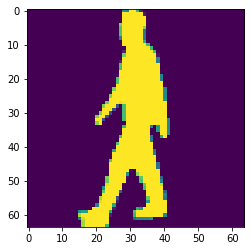

1


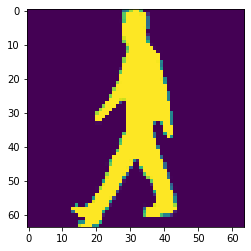

2


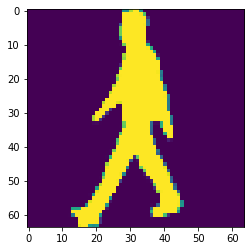

3


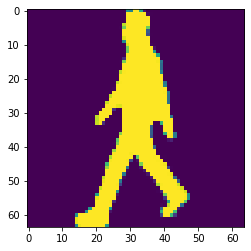

4


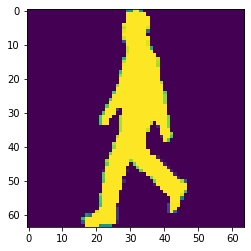

5


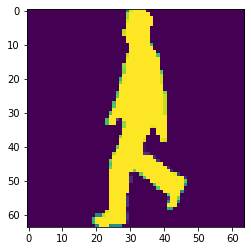

6


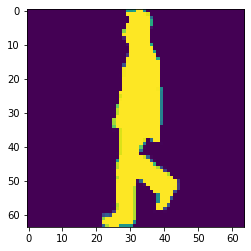

7


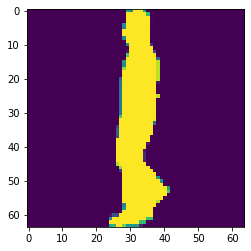

8


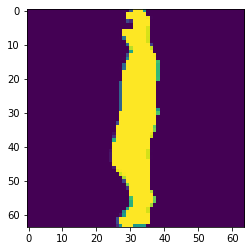

9


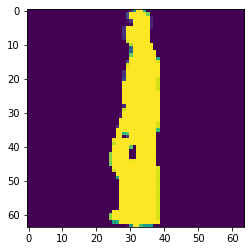

10


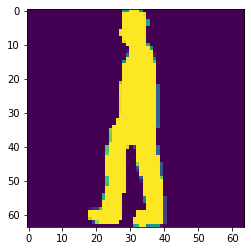

11


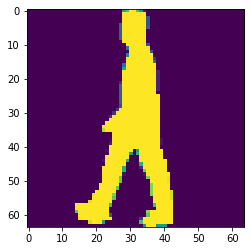

12


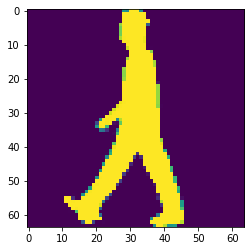

13


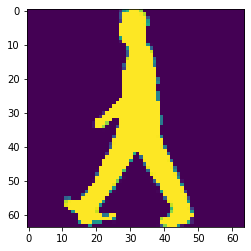

14


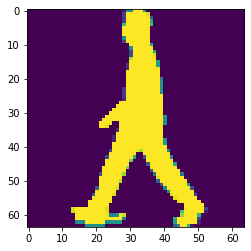

15


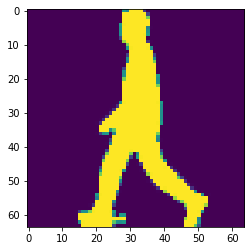

16


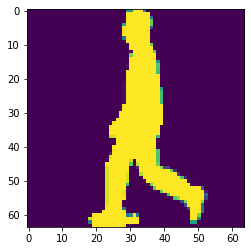

17


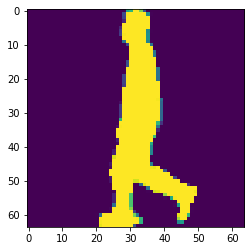

In [32]:
import matplotlib.pyplot as plt
for i in range(18):
    print(i)
    plt.figure(i)
    plt.imshow(frame_list[i])
    plt.show()

In [33]:
import xarray as xr
num_list = list(range(len(frame_list)))
data_dict = xr.DataArray(
    frame_list,
    coords={'frame': num_list},
    dims=['frame', 'img_y', 'img_x'],
)[:, :, 10:-10].astype(
                'float32') / 255.0

In [34]:
seq=np.array(data_dict)
seq = np.float32(seq)
print(seq.shape)
seq = torch.from_numpy(seq)
seq = seq.unsqueeze(1)
seq = Variable(seq.cuda())
print(seq.shape)
seq=seq.unsqueeze(0)

(54, 64, 44)
torch.Size([54, 1, 64, 44])


In [35]:
seq=seq.cuda()
out,att_map1,att_map5=net(seq)

torch.Size([18, 256, 64, 22])
torch.Size([96, 18, 256])


In [22]:
att_map=att_map5.cpu().detach().numpy()
print(att_map.shape)

(192, 18, 18)


0


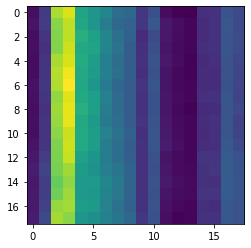

1


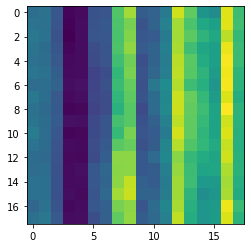

2


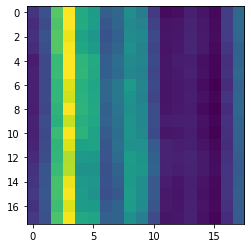

3


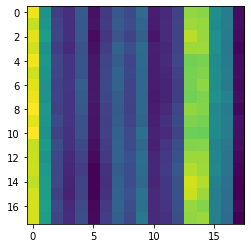

4


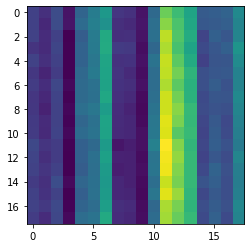

5


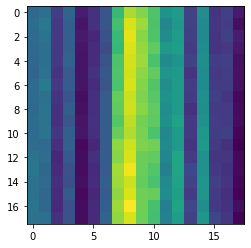

6


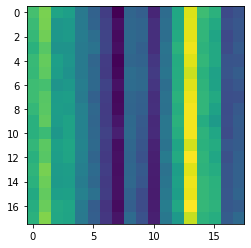

7


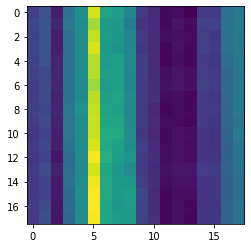

8


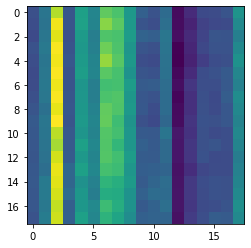

9


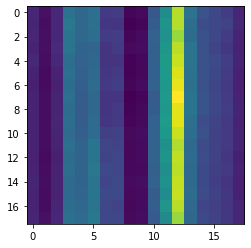

10


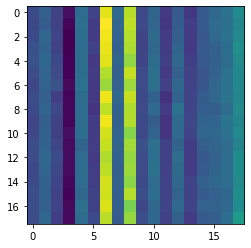

11


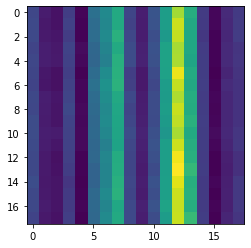

12


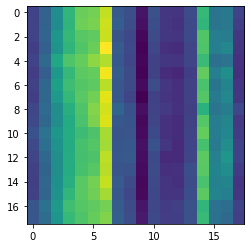

13


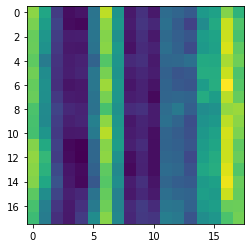

14


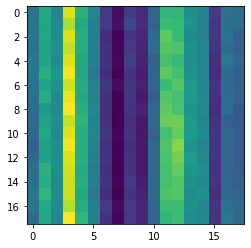

15


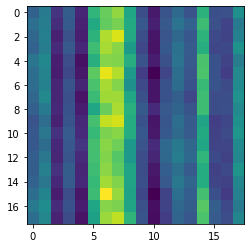

16


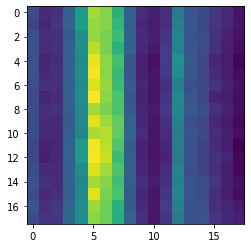

17


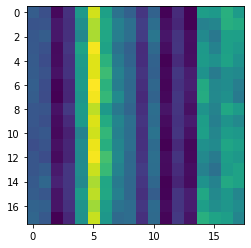

18


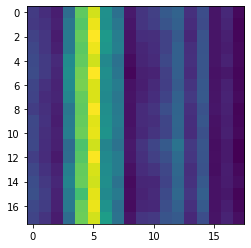

19


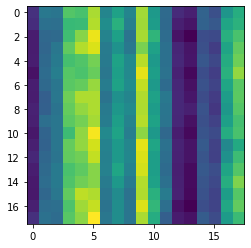

20


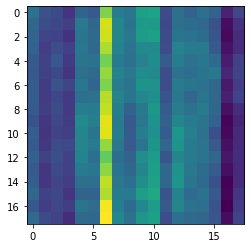

21


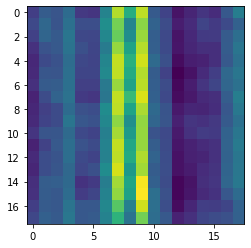

22


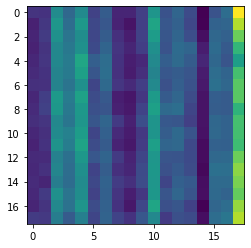

23


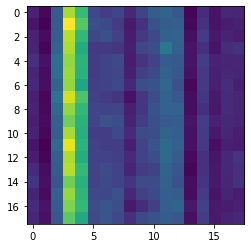

24


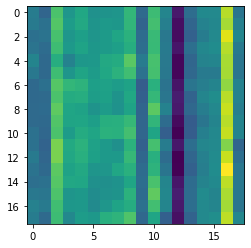

25


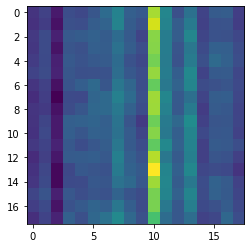

26


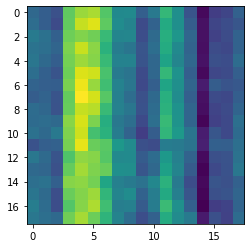

27


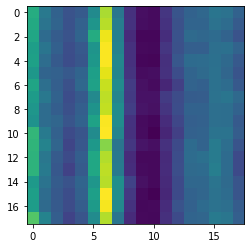

28


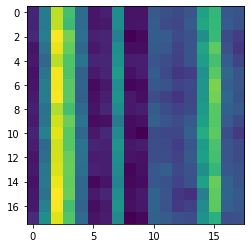

29


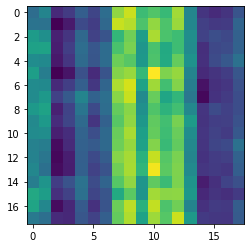

In [37]:
import matplotlib.pyplot as plt
for i in range(30):
    print(i)
    plt.figure(i)
    plt.imshow(att_map[i])
    plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial
from torch.nn.parameter import Parameter
from network.motion_flow import CorrBlock
import torch.nn as nn

def gem(x, p=6.5, eps=1e-6):
    # print('x-',x.shape)
    # print('xpow-',x.clamp(min=eps).pow(p).shape)
    # print(F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).shape)
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).pow(1./p)

class GeM(nn.Module):

    def __init__(self, p=6.5, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # print('p-',self.p)
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

def gem1(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM_1(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM_1,self).__init__()
        #self.p = Parameter(torch.ones(1)*p)
        self.p=1
        self.eps = eps
    def forward(self, x):
        return gem1(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p) + ', ' + 'eps=' + str(self.eps) + ')'


    
class Temporal(nn.Module):
    def __init__(self, inplanes, planes, bias=False, **kwargs):
        super(Temporal, self).__init__()

    def forward(self, x):
        
        out = torch.max(x, 2)[0]
        return out


class BasicConv3d_p(nn.Module):
    def __init__(self, inplanes, planes, kernel=3, bias=False, p=2, FM=False, **kwargs):
        super(BasicConv3d_p, self).__init__()
        self.p = p
        self.fm = FM
        self.convdl = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
        self.convdg = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
    def forward(self, x):
        n, c, t, h, w = x.size()
        scale = h//self.p
        # print('p-',x.shape,n, c, t, h, w,'scale-',scale)
        feature = list()
        for i in range(self.p):
            temp = self.convdl(x[:,:,:,i*scale:(i+1)*scale,:])
            # print(temp.shape,i*scale,(i+1)*scale)
            feature.append(temp)

        outl = torch.cat(feature, 3)
        # print('outl-',outl.shape)
        outl = F.leaky_relu(outl, inplace=True)

        outg = self.convdg(x)
        outg = F.leaky_relu(outg, inplace=True)
        # print('outg-',outg.shape)
        if not self.fm:
            # print('1-1')
            out = outg + outl
        else:
            # print('1-2')
            out = torch.cat((outg, outl), dim=3)
        return out


class BasicConv3d(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(BasicConv3d, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 3, 3), bias=bias, dilation=(dilation, 1, 1), padding=(dilation, 1, 1))

    def forward(self, x):
        out = self.conv1(x)
        out = F.leaky_relu(out, inplace=True)
        return out

class LocaltemporalAG(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(LocaltemporalAG, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), stride=(3,1,1), bias=bias,padding=(0, 0, 0))

    def forward(self, x):
        out1 = self.conv1(x)
        out = F.leaky_relu(out1, inplace=True)
        return out

class LocaltemporalAG33(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(LocaltemporalAG33, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 3, 3), stride=(3,1,1), bias=bias,padding=(0, 1, 1))

    def forward(self, x):
        out1 = self.conv1(x)
        out = F.leaky_relu(out1, inplace=True)
        return out


class C3D_VGG(nn.Module):

    def __init__(self, num_classes=74):
        super(C3D_VGG, self).__init__()
        _set_channels = [32, 64, 128, 256]

        # --------------------------------  2d gei---------------------------------------
        self.conv2dlayer1a = BasicConv3d(1, _set_channels[0], kernel=3)
        # self.conv2dlayer1b = BasicConv3d(_set_channels[0], _set_channels[0])
        self.pool2d1 = LocaltemporalAG(_set_channels[0], _set_channels[0])


        self.conv2dlayer2a = BasicConv3d_p(_set_channels[0], _set_channels[1])
        # self.conv2dlayer2b = BasicConv3d(_set_channels[1], _set_channels[1])
        self.pool2d2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2dlayer25a_3d = BasicConv3d_p(_set_channels[1], _set_channels[2])
        self.conv2dlayer25b_3d = BasicConv3d_p(_set_channels[2], _set_channels[2])

        self.conv2dlayer3a_3d = BasicConv3d_p(_set_channels[2], _set_channels[3])
        self.conv2dlayer3b_3d = BasicConv3d_p(_set_channels[3], _set_channels[3], FM=True)

        self.fpb3d = Temporal(_set_channels[3], _set_channels[3])

        self.Gem = GeM()


        self.bin_numgl = [32*2]
        self.fc_bin = nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[3], _set_channels[3])))
                    ])
                



        self.relu = nn.ReLU()
        for m in self.modules():
            # print('---')
            if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm3d, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        # print(x.shape)
        n, c, t, h, w = x.size()
        if t == 1:
            x = x.repeat(1, 1, 3, 1, 1)
        elif t == 2:
            x = x.repeat(1, 1, 2, 1, 1)
        elif t == 3:
            x = torch.cat((x,x[:,:,0:1,:,:]),dim=2)
        # print(x.shape)

        # ----------------2d--------------------
        x2d = self.conv2dlayer1a(x)
        # x2d = self.conv2dlayer1b(x2d)
        x2d = self.pool2d1(x2d)
        # print('pool2d1-',x2d.shape)
        x2d = self.conv2dlayer2a(x2d)
        # x2d = self.conv2dlayer2b(x2d)
        x2d = self.pool2d2(x2d)
        # print('pool2d2-',x2d.shape)

        x2d = self.conv2dlayer25a_3d(x2d)
        x2d = self.conv2dlayer25b_3d(x2d)

        x2da3d = self.conv2dlayer3a_3d(x2d)
        # print('conv2dlayer3a_3d-',x2da3d.shape)
        x2db3d = self.conv2dlayer3b_3d(x2da3d) # b t 256 64 22 
        # print('conv2dlayer3b_3d-',x2db3d.shape)



        x2db3d = self.fpb3d(x2db3d)
        print('x2db-',x2db3d.shape)

        # xgem = self.Gem(x2db3d)
        # print('xgem-',xgem.shape)

        _, c2d, _, _ = x2db3d.size()

        feature = list()
        for num_bin in self.bin_numgl:
            z = x2db3d.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            z2 = self.Gem(z).squeeze(-1)
            # print('z2-',z2.shape)
            feature.append(z2)
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous()
        print('feature',feature.shape)
        feature = feature.matmul(self.fc_bin[0])
        feature = feature.permute(1, 2, 0).contiguous()
        print('feature',feature.shape)

        return feature,None

class C3D_VGG_angle(nn.Module):

    def __init__(self, num_classes=74):
        super(C3D_VGG_angle, self).__init__()
        _set_channels = [32, 64, 128, 256]

        # --------------------------------  2d gei---------------------------------------
        self.conv2dlayer1a = BasicConv3d(1, _set_channels[0], kernel=3)
        # self.conv2dlayer1b = BasicConv3d(_set_channels[0], _set_channels[0])
        self.pool2d1 = LocaltemporalAG(_set_channels[0], _set_channels[0])


        self.conv2dlayer2a = BasicConv3d_p(_set_channels[0], _set_channels[1])
        # self.conv2dlayer2b = BasicConv3d(_set_channels[1], _set_channels[1])
        self.pool2d2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2dlayer25a_3d = BasicConv3d_p(_set_channels[1], _set_channels[2])
        self.conv2dlayer25b_3d = BasicConv3d_p(_set_channels[2], _set_channels[2],FM=True)

        self.conv2dlayer3a_3d = BasicConv3d_p(_set_channels[2], _set_channels[3])
        self.conv2dlayer3b_3d = BasicConv3d_p(_set_channels[3], _set_channels[3], FM=True)

        self.fpb3d = Temporal(_set_channels[2], _set_channels[2])

        self.Gem = GeM()
        self.avgpool = GeM_1()
        self.cls=nn.Linear(in_features=_set_channels[2], out_features=11)
        
        self.trans_view=nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(64, 128, 256)))]*11)
        self.bin_numgl = [32*2]
        self.fc_bin = nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[3], _set_channels[3])))
                    ])
                



        self.relu = nn.ReLU()
        for m in self.modules():
            # print('---')
            if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm3d, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        # print(x.shape)
        n, c, t, h, w = x.size()
        if t == 1:
            x = x.repeat(1, 1, 3, 1, 1)
        elif t == 2:
            x = x.repeat(1, 1, 2, 1, 1)
        elif t == 3:
            x = torch.cat((x,x[:,:,0:1,:,:]),dim=2)
        # print(x.shape)

        # ----------------2d--------------------
        x2d = self.conv2dlayer1a(x)
        # x2d = self.conv2dlayer1b(x2d)
        x2d = self.pool2d1(x2d)
        print('pool2d1-',x2d.shape)
        x2d = self.conv2dlayer2a(x2d)
        # x2d = self.conv2dlayer2b(x2d)
        x2d = self.pool2d2(x2d)
        print('pool2d2-',x2d.shape)

        x2d = self.conv2dlayer25a_3d(x2d)
        x2d = self.conv2dlayer25b_3d(x2d)
        print('3:',x2d.shape)
        #x2da3d = self.conv2dlayer3a_3d(x2d)
        # print('conv2dlayer3a_3d-',x2da3d.shape)
        #x2db3d = self.conv2dlayer3b_3d(x2da3d)
        # print('conv2dlayer3b_3d-',x2db3d.shape)



        x2db3d = self.fpb3d(x2d)
        print('4:',x2db3d.shape)
        n, c2d, _, _ = x2db3d.size()
        x_feat=self.avgpool(x2db3d)
        x_feat=x_feat.view(n,c2d)
        angle_probe=self.cls(x_feat) # n 11
        _,angle= torch.max(angle_probe, 1)
        
        # print('x2db-',x2db3d.shape)

        # xgem = self.Gem(x2db3d)
        # print('xgem-',xgem.shape)

        _, c2d, _, _ = x2db3d.size()

        feature = list()
        for num_bin in self.bin_numgl:
            z = x2db3d.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            z2 = self.Gem(z).squeeze(-1)
            # print('z2-',z2.shape)
            feature.append(z2)
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous() #  64 n 256
        # print('feature',feature.shape)
        #feature = feature.matmul(self.fc_bin[0]) # 64 n 256
        #feature = feature.permute(1, 2, 0).contiguous() #n 256 64
        feature = feature.permute(1, 0, 2).contiguous()#n 64 256 
        
        feature_rt=[]
        for j in range(feature.shape[0]):
            #print(feature[j].shape)
            feature_now=((feature[j].unsqueeze(1)).bmm(self.trans_view[angle[j]])).squeeze(1) # 64*256
            feature_rt.append(feature_now)
        # print('feature',feature.shape)
        feature = torch.cat([x.unsqueeze(0) for x in feature_rt]) # n 64 256
        feature = feature.permute(0, 2, 1).contiguous()
        #print(feature.shape)
        return feature,None,angle_probe

def params_count(net):
    list1 = []
    for p in net.parameters():
        # print('p-',p.shape)
        list1.append(p)
    # print('len(net.parameters)',len(list1))
    n_parameters = sum(p.numel() for p in net.parameters())
    print('-----Model param: {:.5f}M'.format(n_parameters / 1e6))
    # print('-----Model memory: {:.5f}M'.format(n_parameters/1e6))
    return n_parameters


def c3d_vgg_Fusion(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = C3D_VGG(**kwargs)
    return model


class C3D_VGG_angle_emb(nn.Module):

    def __init__(self, num_classes=74):
        super(C3D_VGG_angle_emb, self).__init__()
        _set_channels = [32, 64, 128, 256]
        self.view_nums=11
        # --------------------------------  2d gei---------------------------------------
        self.conv2dlayer1a = BasicConv3d(1, _set_channels[0], kernel=3)
        # self.conv2dlayer1b = BasicConv3d(_set_channels[0], _set_channels[0])
        self.pool2d1 = LocaltemporalAG(_set_channels[0], _set_channels[0])


        self.conv2dlayer2a = BasicConv3d_p(_set_channels[0], _set_channels[1])
        # self.conv2dlayer2b = BasicConv3d(_set_channels[1], _set_channels[1])
        self.pool2d2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2dlayer25a_3d = BasicConv3d_p(_set_channels[1], _set_channels[2])
        self.conv2dlayer25b_3d = BasicConv3d_p(_set_channels[2], _set_channels[2],FM=True)

        self.conv2dlayer3a_3d = BasicConv3d_p(_set_channels[2], _set_channels[3])
        self.conv2dlayer3b_3d = BasicConv3d_p(_set_channels[3], _set_channels[3], FM=True)

        self.fpb3d = Temporal(_set_channels[2], _set_channels[2])

        self.Gem = GeM()
        self.avgpool = GeM_1()
        self.cls=nn.Linear(in_features=_set_channels[2], out_features=11)
        '''
        self.trans_view=nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(64, 128, 256)))]*11)
        '''



        self.view_embedding_64 = nn.Parameter(torch.randn(self.view_nums,_set_channels[1],1))

        self.bin_numgl = [32*2]
        self.fc_bin = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[2]+_set_channels[1], _set_channels[3])))
                    
                



        self.relu = nn.ReLU()
        for m in self.modules():
            # print('---')
            if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm3d, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        # print(x.shape)
        x=x.permute(0,2,1,3,4).contiguous()
        n, c, t, h, w = x.size()
        if t == 1:
            x = x.repeat(1, 1, 3, 1, 1)
        elif t == 2:
            x = x.repeat(1, 1, 2, 1, 1)
        elif t == 3:
            x = torch.cat((x,x[:,:,0:1,:,:]),dim=2)
        # print(x.shape)

        # ----------------2d--------------------
        x2d = self.conv2dlayer1a(x)
        # x2d = self.conv2dlayer1b(x2d)
        x2d = self.pool2d1(x2d)
        #print('pool2d1-',x2d.shape)
        x2d = self.conv2dlayer2a(x2d)
        # x2d = self.conv2dlayer2b(x2d)
        x2d = self.pool2d2(x2d)
        #print('pool2d2-',x2d.shape)

        x2d = self.conv2dlayer25a_3d(x2d)
        x2d = self.conv2dlayer25b_3d(x2d) # b 256 t 64 22


        #print('3:',x2d.shape)
        #x2da3d = self.conv2dlayer3a_3d(x2d)
        # print('conv2dlayer3a_3d-',x2da3d.shape)
        #x2db3d = self.conv2dlayer3b_3d(x2da3d)
        # print('conv2dlayer3b_3d-',x2db3d.shape)



        x2db3d = self.fpb3d(x2d)
        #print('4:',x2db3d.shape)
        n, c2d, _, _ = x2db3d.size()
        x_feat=self.avgpool(x2db3d)
        x_feat=x_feat.view(n,c2d)
        angle_probe=self.cls(x_feat) # n 11
        _,angle= torch.max(angle_probe, 1)
        
        #print('x2db-',x2db3d.shape)

        # xgem = self.Gem(x2db3d)
        # print('xgem-',xgem.shape)

        _, c2d, _, _ = x2db3d.size()

        feature = list()
        for num_bin in self.bin_numgl:
            z = x2db3d.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            #z2 = self.Gem(z).squeeze(-1)
            z2=torch.cat((self.Gem(z).squeeze(-1),self.view_embedding_64[angle].expand(-1,-1,num_bin)),1)
            # print('z2-',z2.shape)
            feature.append(z2)
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous() #  64 n 256
        #print('feature',feature.shape)
        feature = feature.matmul(self.fc_bin) # 64 n 256
        feature = feature.permute(1, 2, 0).contiguous()
        #feature = feature.permute(1, 2, 0).contiguous() #n 256 64
        #feature = feature.permute(1, 0, 2).contiguous()#n 64 256 
        '''
        feature_rt=[]
        for j in range(feature.shape[0]):
            #print(feature[j].shape)
            feature_now=((feature[j].unsqueeze(1)).bmm(self.trans_view[angle[j]])).squeeze(1) # 64*256
            feature_rt.append(feature_now)
        # print('feature',feature.shape)
        feature = torch.cat([x.unsqueeze(0) for x in feature_rt]) # n 64 256
        feature = feature.permute(0, 2, 1).contiguous()
        #print(feature.shape)
        '''
        return feature,angle_probe



class C3D_VGG_angle_emb_motion(nn.Module):

    def __init__(self, num_classes=74):
        super(C3D_VGG_angle_emb_motion, self).__init__()
        _set_channels = [32, 64, 128, 256]
        self.view_nums=11
        self.radius=3
        # --------------------------------  2d gei---------------------------------------
        self.conv2dlayer1a = BasicConv3d(1, _set_channels[0], kernel=3)
        # self.conv2dlayer1b = BasicConv3d(_set_channels[0], _set_channels[0])
        self.pool2d1 = LocaltemporalAG(_set_channels[0], _set_channels[0])


        self.conv2dlayer2a = BasicConv3d_p(_set_channels[0], _set_channels[1])
        # self.conv2dlayer2b = BasicConv3d(_set_channels[1], _set_channels[1])
        self.pool2d2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2dlayer25a_3d = BasicConv3d_p(_set_channels[1], _set_channels[2])
        self.conv2dlayer25b_3d = BasicConv3d_p(_set_channels[2], _set_channels[2],FM=True)

        self.conv2dlayer3a_3d = BasicConv3d_p(_set_channels[2], _set_channels[3])
        self.conv2dlayer3b_3d = BasicConv3d_p(_set_channels[3], _set_channels[3], FM=True)

        self.fpb3d = Temporal(_set_channels[2], _set_channels[2])

        self.Gem = GeM()
        self.avgpool = GeM_1()
        self.cls=nn.Linear(in_features=_set_channels[2], out_features=11)
        '''
        self.trans_view=nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(64, 128, 256)))]*11)
        '''
        self.view_embedding_64 = nn.Parameter(torch.randn(self.view_nums,_set_channels[1],1))

        self.bin_numgl = [32*2]
        self.fc_bin = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[2]+_set_channels[1], _set_channels[3])))
        
        
        self.view_embedding_64_motion = nn.Parameter(torch.randn(self.view_nums,_set_channels[1],1))

        self.bin_numgl_motion = [8]
        self.fc_bin_motion = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl_motion), _set_channels[2]+_set_channels[1], _set_channels[3])))
                    

        self.motion_extract=CorrBlock(num_levels=2, radius=3)
        self.motion_conv1=BasicConv3d(2*(self.radius*2+1)**2,_set_channels[2],kernel_size=3)
        self.motion_conv2=LocaltemporalAG33(_set_channels[2], _set_channels[2])
            


        self.relu = nn.ReLU()
        for m in self.modules():
            # print('---')
            if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm3d, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        # print(x.shape)
        x=x.permute(0,2,1,3,4).contiguous()
        n, c, t, h, w = x.size()
        if t == 1:
            x = x.repeat(1, 1, 3, 1, 1)
        elif t == 2:
            x = x.repeat(1, 1, 2, 1, 1)
        elif t == 3:
            x = torch.cat((x,x[:,:,0:1,:,:]),dim=2)
        # print(x.shape)

        # ----------------2d--------------------
        x2d = self.conv2dlayer1a(x)
        # x2d = self.conv2dlayer1b(x2d)
        x2d = self.pool2d1(x2d)
        #print('pool2d1-',x2d.shape)
        x2d = self.conv2dlayer2a(x2d)
        # x2d = self.conv2dlayer2b(x2d)
        x2d = self.pool2d2(x2d)
        #print('pool2d2-',x2d.shape)

        x2d = self.conv2dlayer25a_3d(x2d)
        x2d = self.conv2dlayer25b_3d(x2d) # b t 256 64 22


        b,c,t,h,w=x2d.shape
        x2d_motion=x2d[:,:,:,h//2:,:].clone()
        



        x2db3d = self.fpb3d(x2d)
        #print('4:',x2db3d.shape)
        n, c2d, _, _ = x2db3d.size()
        x_feat=self.avgpool(x2db3d)
        x_feat=x_feat.view(n,c2d)
        angle_probe=self.cls(x_feat) # n 11
        _,angle= torch.max(angle_probe, 1)
        
        
        b,c,t,h,w=x2d_motion.shape
        x2d_motion=x2d_motion.view(b*c,t,h,w)
        x2d_motion=F.avg_pool2d(x2d_motion, kernel_size=(2,2))
        x2d_motion=x2d_motion.view(b,c,t,h//2,w//2)
        x2d_motion=self.motion_extract(x2d_motion) # b (2*r+1)**2*2 t 16 11
        x2d_motion=self.motion_conv1(x2d_motion) 
        x2d_motion=self.motion_conv2(x2d_motion) # b 256 t//3 16 11
        b,c,t,h,w=x2d_motion.shape
        x2d_motion=x2d_motion.permute(0,1,3,4,2).contiguous()
        x2d_motion=x2d_motion.view(b,c,h,w*t)
        n,c2d,_,_=x2d_motion.shape
        feature_motion=[]
        for num_bin in self.bin_numgl_motion:
            z = x2d_motion.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            #z2 = self.Gem(z).squeeze(-1)
            z2=torch.cat((self.Gem(z).squeeze(-1),self.view_embedding_64_motion[angle].expand(-1,-1,num_bin)),1)
            # print('z2-',z2.shape)
            feature_motion.append(z2)
        feature_motion = torch.cat(feature_motion, 2).permute(2, 0, 1).contiguous() #  8 n 256
        #print('feature',feature.shape)
        feature_motion = feature_motion.matmul(self.fc_bin_motion) # 8 n 256
        feature_motion = feature_motion.permute(1, 2, 0).contiguous()
        #print('3:',x2d.shape)
        #x2da3d = self.conv2dlayer3a_3d(x2d)
        # print('conv2dlayer3a_3d-',x2da3d.shape)
        #x2db3d = self.conv2dlayer3b_3d(x2da3d)
        # print('conv2dlayer3b_3d-',x2db3d.shape)
        
        #print('x2db-',x2db3d.shape)

        # xgem = self.Gem(x2db3d)
        # print('xgem-',xgem.shape)

        _, c2d, _, _ = x2db3d.size()

        feature = list()
        for num_bin in self.bin_numgl:
            z = x2db3d.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            #z2 = self.Gem(z).squeeze(-1)
            z2=torch.cat((self.Gem(z).squeeze(-1),self.view_embedding_64[angle].expand(-1,-1,num_bin)),1)
            # print('z2-',z2.shape)
            feature.append(z2)
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous() #  64 n 256
        #print('feature',feature.shape)
        feature = feature.matmul(self.fc_bin) # 64 n 256
        feature = feature.permute(1, 2, 0).contiguous()
        feature=torch.cat([feature_motion,feature],2)
        #feature = feature.permute(1, 2, 0).contiguous() #n 256 64
        #feature = feature.permute(1, 0, 2).contiguous()#n 64 256 
        '''
        feature_rt=[]
        for j in range(feature.shape[0]):
            #print(feature[j].shape)
            feature_now=((feature[j].unsqueeze(1)).bmm(self.trans_view[angle[j]])).squeeze(1) # 64*256
            feature_rt.append(feature_now)
        # print('feature',feature.shape)
        feature = torch.cat([x.unsqueeze(0) for x in feature_rt]) # n 64 256
        feature = feature.permute(0, 2, 1).contiguous()
        #print(feature.shape)
        '''
        return feature,angle_probe



net=C3D_VGG_angle_emb_motion()
x=torch.randn(2,30,1,64,44)
out1,out2=net(x)

In [6]:
out1.shape

torch.Size([2, 256, 72])